<a href="https://colab.research.google.com/github/IralaElbio/DataScience/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 681.5 kB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
import ast
from sklearn.utils import resample
import category_encoders as ce
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/dataset_v2/train.parq")
Shodan = pd.read_csv("/content/drive/MyDrive/dataset_v2/shodan_df_hashed.csv")

In [ ]:
data.drop_duplicates(subset =["watcher_as_num","attacker_ip_enum","attack_type"], inplace = True)

data.drop(["watcher_as_num", "watcher_uuid_enum","attacker_as_num","attack_time"],axis = 1,inplace = True)

lower the names because maybe there are names that differ with only a capital letter

In [ ]:
RANDOM_STATE = 14
data["attacker_as_name"] = data["attacker_as_name"].map(lambda x: x.lower())
data["watcher_as_name"] = data["watcher_as_name"].map(lambda x: x.lower())

# info df

null analisis

In [ ]:
data.isna().sum()/data.shape[0] * 100

watcher_country     0.658598
watcher_as_name     0.658311
attacker_country    0.020323
attacker_as_name    0.073945
attack_type         0.000000
attacker_ip_enum    0.000000
label               0.000000
dtype: float64

add unknown category to the null data

In [ ]:
data["attacker_as_name"].fillna("unknown", inplace = True)
data["watcher_as_name"].fillna("unknown", inplace = True)

data["attacker_country"] = data["attacker_country"].cat.add_categories("unknown")
data["attacker_country"].fillna("unknown", inplace = True)

no hay nulos

In [ ]:
data.isna().sum()/data.shape[0] * 100

watcher_country     0.658598
watcher_as_name     0.000000
attacker_country    0.000000
attacker_as_name    0.000000
attack_type         0.000000
attacker_ip_enum    0.000000
label               0.000000
dtype: float64

# feature engineering

## concatenate the names of the countries

In [ ]:
data["Countries"] = data["watcher_country"].astype(str) + "-" + data["attacker_country"].astype(str)

In [ ]:
data.drop(["watcher_country","attacker_country"], axis = 1, inplace = True)

## Shodan Ports


Functions to separate ports and protocols

In [ ]:
def Port(keys):
  res = set()
  if len(keys) == 0:
    res.add("unknown")
    return res
  for key in keys:
    puerto = key.split("/")[0]
    res.add(puerto)
  return res


def Protocol(keys):
  res = set()
  if len(keys) == 0:
    res.add("unknown")
    return res
  for key in keys:
    puerto = key.split("/")[1]
    res.add(puerto)
  return res

In [ ]:
Shodan["port"] = Shodan["shodan_info"].map(lambda x: Port(ast.literal_eval(x).keys()))
Shodan["protocol"] = Shodan["shodan_info"].map(lambda x: Protocol(ast.literal_eval(x).keys()))

In [ ]:
Shodan.head(5)

,shodan_info,attacker_ip_enum,port,protocol
0,{},5915,{unknown},{unknown}
1,"{'22/tcp': {'headers_hash': None, 'jarm': None...",3325,{22},{tcp}
2,{},8416,{unknown},{unknown}
3,{},1213,{unknown},{unknown}
4,{},9185,{unknown},{unknown}


Merge data and Shodan ports

In [ ]:
data = data.merge(Shodan[["attacker_ip_enum","port"]], on = "attacker_ip_enum", how = "left")

### Protocol

In [ ]:
protocol = Shodan[["attacker_ip_enum","protocol","port"]].explode("protocol")

In [ ]:
protocol = protocol.groupby(["attacker_ip_enum","protocol"]).count().unstack().fillna(0).reset_index()

In [ ]:
protocol.columns = ["attacker_ip_enum","unknown","tcp","udp"]

In [ ]:
data = data.merge(protocol, on = "attacker_ip_enum", how = "left")

## Take the service in attack_type

In [ ]:
data["service"] = data["attack_type"].map(lambda x: x.split(":")[0])
data.drop("attack_type",axis = 1, inplace = True)

# Data management

## Create validation and training set

### Validation and test mantaining data dispersion

GroupShuffleSplit to separate the data with label 0 and label 1 in a 80-20 to mantain data dispersion

In [ ]:
data1 = data[data["label"] == 1]
data0 = data[data["label"] == 0]

In [ ]:
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = RANDOM_STATE)
split0 = splitter.split(data0, groups= data0["attacker_ip_enum"])
train_inds0, test_inds0 = next(split0)

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = RANDOM_STATE)
split1 = splitter.split(data1, groups= data1["attacker_ip_enum"])
train_inds1, test_inds1 = next(split1)

train0 = data0.iloc[train_inds0]
valid0 = data0.iloc[test_inds0]

train1 = data1.iloc[train_inds1]
valid1 = data1.iloc[test_inds1]

Concat the data with 0 and 1

In [ ]:
train = shuffle(pd.concat([train1,train0]), random_state= RANDOM_STATE)
valid = shuffle(pd.concat([valid1,valid0]), random_state= RANDOM_STATE)

clear memory

In [ ]:
datos1 = ""
datos0 = ""
datos = ""
train1 = ""
train0 = ""
valid0 = ""
valid1 = ""

# Means

## Attacker_as_name vs ports

Same feature that I use in Random Forest. Get the max mean between as_name and port.

### train

In [ ]:
att_as_name_vs_p = train[["attacker_as_name", "label", "port"]].explode("port")

In [ ]:
att_as_name_vs_p = att_as_name_vs_p.groupby(["attacker_as_name","port"]).mean()

In [ ]:
att_as_name_vs_p.columns = ["mean"]

In [ ]:
att_as_name_vs_p_map = att_as_name_vs_p["mean"].to_dict()
att_as_name_vs_p = ""

In [ ]:
train["att_as_name_vs_ports"] = train["attacker_as_name"].apply(lambda x: [str(x)]) + train["port"].apply(list)

In [ ]:
def max_mean_att_port(list_p):
  as_name = list_p[0]
  res = []
  for port in list_p[1:]:
    res.append(att_as_name_vs_p_map.get((as_name, port), 0))
  return max(res)


In [ ]:
train["att_as_name_vs_ports"] = train["att_as_name_vs_ports"].map(lambda x: max_mean_att_port(x))

In [ ]:
train.drop(["attacker_as_name"], axis = 1, inplace = True)

### valid

In [ ]:
valid["att_as_name_vs_ports"] = valid["attacker_as_name"].apply(lambda x: [str(x)]) + valid["port"].apply(list)

In [ ]:
valid["att_as_name_vs_ports"] = valid["att_as_name_vs_ports"].map(lambda x: max_mean_att_port(x))

In [ ]:
valid.drop(["attacker_as_name"], axis = 1, inplace = True)

## Ports Mean

### train

Same case of Random Fortest, I get the max mean of each port then I devide for the length to either "normalize" or "pelalize" rows with numerous open ports

In [ ]:
ports = train[["label","port"]]

In [ ]:
portdata = ports.explode("port").groupby("port").agg({"label": ["count","mean","sum"]})

In [ ]:
portdata.columns = ["total", "mean", "sum"]

In [ ]:
portdata_dict = portdata["mean"].to_dict()
portdata = ""

In [ ]:
def mean_port(ports):
  mean = []
  for port in ports:
    mean.append(portdata_dict.get(port,0))
  return max(mean) / len(ports)


In [ ]:
train["port"] = train["port"].map(lambda x: mean_port(x))

### valid

In [ ]:
valid["port"] = valid["port"].map(lambda x: mean_port(x))

# Encoding

## divide train and validation

In [ ]:
train.drop_duplicates(inplace = True)
valid.drop_duplicates(inplace = True)

In [ ]:
train.drop("attacker_ip_enum", inplace = True, axis = 1)
valid.drop("attacker_ip_enum", inplace = True, axis = 1)

In [ ]:
y_train = train["label"]
x_train = train.drop("label", axis=1)

y_valid = valid["label"]
x_valid = valid.drop("label", axis=1)

clear memory

In [ ]:
train = ""
valid = ""

## Binary colums

In [ ]:
binary_col = ["Countries","watcher_as_name"]

encoder = ce.BinaryEncoder(cols= binary_col)

x_train = encoder.fit_transform(x_train)

x_valid = encoder.transform(x_valid)

binary columns to int8 for memory optimization

In [ ]:
binary_col = [col for col in x_train.columns if "Countries" in col or "watcher" in col]

In [ ]:
x_train[binary_col] = x_train[binary_col].astype('int8')

## Service OHE

In [ ]:
ohe_service = OneHotEncoder(drop = "first")
service_encoded = ohe_service.fit_transform(x_train[["service"]]).toarray()

x_train.drop("service", inplace = True, axis = 1)
x_train[ohe_service.categories_[0][1:]] = service_encoded

In [ ]:
service_encoded = ohe_service.transform(x_valid[["service"]]).toarray()

x_valid.drop("service", inplace = True, axis = 1)
x_valid[ohe_service.categories_[0][1:]] = service_encoded

# XGBoost Default

In [ ]:
xgb_1 = xgb.XGBClassifier(random_state = RANDOM_STATE)

xgb_1.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=14, ...)

In [ ]:
y_pred = xgb_1.predict(x_valid)

In [ ]:
f1_score(y_valid, y_pred)

0.7158398960785907

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    430914
           1       0.76      0.68      0.72     12974

    accuracy                           0.98    443888
   macro avg       0.87      0.84      0.85    443888
weighted avg       0.98      0.98      0.98    443888



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

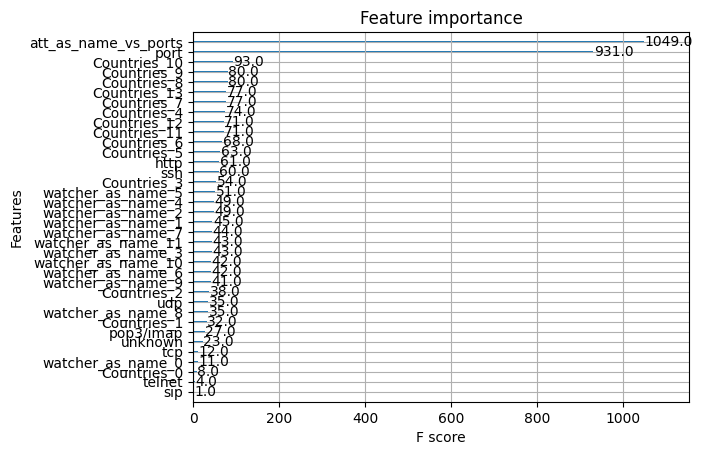

In [ ]:
xgb.plot_importance(xgb_1)

# XGBoost Random Seach

In [ ]:
param_dist = {
    'max_depth': range(3, 10, 2),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(50, 201, 10),
    'min_child_weight': range(1, 6, 2),
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'reg_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'scale_pos_weight': [1, 2, 5],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [ ]:
xgb_2 = xgb.XGBClassifier(random_state = RANDOM_STATE)

In [ ]:
xgb_randomF = RandomizedSearchCV(xgb_2, param_distributions=param_dist, n_iter= 20, cv=5, scoring='f1', random_state=RANDOM_STATE)

xgb_randomF.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(3, 10, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(50, 201, 10),
                                        'reg_alpha': [0, 0.001, 0.005, 0.01,
                                                      0.05, 0.1, 1],
                                        'reg_lambda': [0.1, 0.5, 1.0, 2.0, 5.0,
                                                       10.0],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=14, scoring='f1')

In [ ]:
xgb_randomF.best_score_

0.8913495697285047

In [ ]:
xgb_randomF.best_params_

{'subsample': 0.6,
 'scale_pos_weight': 2,
 'reg_lambda': 10.0,
 'reg_alpha': 0,
 'n_estimators': 180,
 'min_child_weight': 1,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.6,
 'colsample_bylevel': 0.6}

In [ ]:
xgb_randoms = xgb_randomF.best_estimator_

In [ ]:
pred = xgb_randoms.predict(x_valid)

In [ ]:
f1_score(y_valid, pred)

0.7169598647397448

In [ ]:
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    430914
           1       0.75      0.69      0.72     12974

    accuracy                           0.98    443888
   macro avg       0.87      0.84      0.85    443888
weighted avg       0.98      0.98      0.98    443888



# Test Kaggle

In [ ]:
test = pd.read_parquet("/content/drive/MyDrive/dataset_v2/test.parq")

In [ ]:
test.drop(["watcher_as_num", "watcher_uuid_enum","attacker_as_num","attack_time"],axis = 1,inplace = True)

In [ ]:
test["attacker_as_name"] = test["attacker_as_name"].map(lambda x: x.lower())
test["watcher_as_name"] = test["watcher_as_name"].map(lambda x: x.lower())

## INFO Test

In [ ]:
test.isna().sum()/test.shape[0] * 100

watcher_country     0.670373
watcher_as_name     0.670340
attacker_country    0.015587
attacker_as_name    0.237476
attack_type         0.000000
attacker_ip_enum    0.000000
dtype: float64

In [ ]:
test["attacker_as_name"].fillna("unknown", inplace = True)

test["watcher_country"] = test["watcher_country"].cat.add_categories("unknown")
test["watcher_country"].fillna("unknown", inplace = True)

test["attacker_country"] = test["attacker_country"].cat.add_categories("unknown")
test["attacker_country"].fillna("unknown", inplace = True)

In [ ]:
test.isna().sum()/test.shape[0] * 100

watcher_country     0.00000
watcher_as_name     0.67034
attacker_country    0.00000
attacker_as_name    0.00000
attack_type         0.00000
attacker_ip_enum    0.00000
dtype: float64

## Prepare Test for prediction

In [ ]:
test.drop_duplicates("attacker_ip_enum", inplace = True)

In [ ]:
test["Countries"] = test["watcher_country"].astype(str) + "-" + test["attacker_country"].astype(str)

In [ ]:
test.drop(["watcher_country","attacker_country"], axis = 1, inplace = True)

add ports and protocols

In [ ]:
test = test.merge(Shodan[["attacker_ip_enum","port"]], on = "attacker_ip_enum", how = "left")
test = test.merge(protocol, on = "attacker_ip_enum", how = "left")

Separate attack_type

In [ ]:
test["service"] = test["attack_type"].map(lambda x: x.split(":")[0])
test.drop("attack_type",axis = 1, inplace = True)

mean attack as name vs ports

In [ ]:
test["att_as_name_vs_ports"] = test["attacker_as_name"].apply(lambda x: [str(x)]) + test["port"].apply(list)

In [ ]:
test["att_as_name_vs_ports"] = test["att_as_name_vs_ports"].map(lambda x: max_mean_att_port(x))

In [ ]:
test.drop(["attacker_as_name"], axis = 1, inplace = True)

Agrego el mean puertos

In [ ]:
test["port"] = test["port"].map(lambda x: mean_port(x))

Saco la IP y me la guardo para luego poder identificar las predicciones

In [ ]:
testIP = test['attacker_ip_enum']

test.drop("attacker_ip_enum", axis = 1, inplace = True)

## OHE

In [ ]:
test = encoder.transform(test)

In [ ]:
service_encoded = ohe_service.transform(test[["service"]]).toarray()

test.drop("service", inplace = True, axis = 1)
test[ohe_service.categories_[0][1:]] = service_encoded

# predecir

In [ ]:
pred = pd.Series(xgb_randoms.predict(test), index = testIP.to_frame().set_index("attacker_ip_enum").index).rename("prediction")

In [ ]:
pred.to_csv("XGBoostFinal.csv")

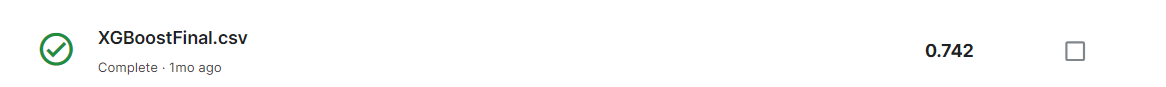